# Notebook for defining sigma levels for analysis

In order for correlations between CSHT and ASC speed in $\sigma$ levels to work, we need to have most of the sigma levels without gaps in either transport or speed. Which means we need a variable density categorization for the deepest levels. This notebook aims to chose this density categorization.

In [1]:
import cosima_cookbook as cc
from cosima_cookbook import distributed as ccd
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import glob,os
import cmocean.cm as cmocean
from tqdm import tqdm
from gsw import sigma0
from gsw import SA_from_SP
from gsw import p_from_z
from gsw import sigma0

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

In [2]:
client = Client(n_workers=28, memory_limit='190GiB')
client

<Client: 'tcp://127.0.0.1:42283' processes=28 threads=28, memory=5.20 TiB>

2024-07-18 10:41:33,406 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:41925' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('concatenate-open_dataset-salt-getitem-06c97d3c211cc5adecc096d91b05dcc2', 510, 0, 3, 7), ('getitem-a65c3eea79b649db8334263d020c74c4', 463, 0, 3, 8), ('getitem-06c97d3c211cc5adecc096d91b05dcc2', 510, 0, 3, 9), ('getitem-06c97d3c211cc5adecc096d91b05dcc2', 510, 0, 3, 8), ('getitem-a65c3eea79b649db8334263d020c74c4', 463, 0, 3, 9), ('concatenate-open_dataset-temp-getitem-a65c3eea79b649db8334263d020c74c4', 463, 0, 3, 7)} (stimulus_id='handle-worker-cleanup-1721263293.4004226')
2024-07-18 10:41:33,958 - distributed.nanny - WARNING - Restarting worker
2024-07-18 10:41:43,619 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:37481' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('rechunk-merge-3684acb46d4742fc92704326c1be8687', 574, 0, 3, 9), ('r

In [4]:
session = cc.database.create_session()
exp = '01deg_jra55v140_iaf_cycle3'
lat_range = slice(-90,-59)
depth_slice=slice(700,1700) # we only care about what is deeper than 700m, and shallower than 1600m

In [5]:
#importing geographical coordinates
yt_ocean = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean = yt_ocean.sel(yt_ocean=lat_range)
yu_ocean = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean = yu_ocean.sel(yu_ocean=lat_range)
xt_ocean = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean = cc.querying.getvar(exp,'xu_ocean',session,n=1) 
geolon_t = cc.querying.getvar(exp, 'geolon_t', session, n=1)
geolat_t = cc.querying.getvar(exp, 'geolat_t', session, n=1)
st_ocean = cc.querying.getvar(exp,'st_ocean',session,n=1).sel(st_ocean=depth_slice).load()

Importing T and S to calculate sigma.

In [7]:
Temp = (cc.querying.getvar(exp,'temp',session,ncfile='%daily%',chunks={'time':'200gb'})\
        .sel(yt_ocean=lat_range).sel(st_ocean=depth_slice)) - 273.15
Salt = cc.querying.getvar(exp,'salt',session,ncfile='%daily%',chunks={'time':'200gb'})\
.sel(yt_ocean=lat_range).sel(st_ocean=depth_slice)

Creating depth nd pressure tiles for calculating the density

In [8]:
time_monthly=Salt.time #not really monthly, it is daily. Just maintained the n ame from a previous code
lon_t = geolon_t.sel(yt_ocean=lat_range).expand_dims(st_ocean=st_ocean).expand_dims(time=time_monthly)
lat_t = geolat_t.sel(yt_ocean=lat_range).expand_dims(st_ocean=st_ocean).expand_dims(time=time_monthly)

depth_tile = (lat_t*0 + 1) * (-st_ocean)

In [9]:
pressure = xr.DataArray(p_from_z(depth_tile, lat_t),\
                        coords = [time_monthly,st_ocean, yt_ocean.sel(yt_ocean=lat_range), xt_ocean]\
                        ,dims = ['time','st_ocean','yt_ocean', 'xt_ocean'], \
                        name = 'pressure', attrs = {'units':'dbar'})

In [10]:
ABS_Salt = SA_from_SP(Salt, pressure, lon_t, lat_t)

Finally calculating $\sigma_0$

In [11]:
Sigma0 = sigma0(ABS_Salt,Temp)
Sigma0.name='potrho0'
Sigma0.attrs= {'units':'kg/m3 -1000'}

We are actually interested in the minimum density along the bottom of the contour. to reduce computing load, we can extract the minimum along time now, and do the rest of the operations with an array already reduced in dimension.

In [12]:
Sigma0 = Sigma0.min('time')
Sigma0

<xarray.DataArray 'potrho0' (st_ocean: 9, yt_ocean: 510, xt_ocean: 3600)> Size: 132MB
dask.array<_nanmin_skip-aggregate, shape=(9, 510, 3600), dtype=float64, chunksize=(9, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 72B 766.1 843.0 926.6 ... 1.453e+03 1.581e+03
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    geolon_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(510, 720), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 7MB dask.array<chunksize=(510, 720), meta=np.ndarray>

Interpolating sigma into the heat transport grid

In [13]:
Sigma0_u =Sigma0.interp(xt_ocean=xu_ocean)
Sigma0_v =Sigma0.interp(yt_ocean=yu_ocean)

Now the difficult step.... can we compute this data without crashing?

In [16]:
%%time
Sigma0_u.compute()
Sigma0_v.compute()

2024-07-18 10:41:59,056 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:43391 -> tcp://127.0.0.1:35091
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
ConnectionResetError: [Errno 104] Connection reset by peer

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/worker.py", line 1783, in get_data
    response = await comm.read(deserializers=serializers)
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distr

KilledWorker: Attempted to run task ('rechunk-split-rechunk-merge-3684acb46d4742fc92704326c1be8687', 695, 0, 0, 11) on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:46201. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.

2024-07-18 10:50:54,152 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 133.06 GiB -- Worker memory limit: 190.00 GiB
2024-07-18 10:51:05,033 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 152.20 GiB -- Worker memory limit: 190.00 GiB
2024-07-18 10:51:05,034 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 152.20 GiB -- Worker memory limit: 190.00 GiB
2024-07-18 10:51:15,049 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate 

Making sure we have a density value for the edges of the U matrix

In [ ]:
Sigma0_u =Sigma0_u.transpose('st_ocean', 'yt_ocean','xu_ocean')
Sigma0_u[:,:,-1]=(Sigma0_u[:,:,-2].values + Sigma0_u[:,:,0].values)/2 #this is the low step. maybe I dont need to do that now


In [3]:
# Load the along-slope velocity field
u_along = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/Binned_ASC_speed/OM2_IAF/Binned_Antarctic_slope_contour_1km_velocities*').resample(time='1M').mean()
u_along_unbinned = xr.open_mfdataset('/g/data/v45/wf4500/ASC_project_files/ASC_speed/OM2_IAF/*').resample(time='1M').mean()
# Load CSHT field
CSHT_along = xr.open_mfdataset(\
    '/g/data/v45/wf4500/ASC_project_files/Cross_slope_heat_transport/OM2_IAF/daily_z/*').resample(time='1M').mean()

In [4]:
# importing it
MT = xr.open_mfdataset('/g/data/e14/cs6673/iav_AABW/data_iav_AABW_final/vol_trans_across_contour_01deg_jra55v140_iaf_cycle3_1d*').resample(time='1M').mean()
MT=MT.vol_trans_across_contour.load()

In [5]:
# unbinned CSHT monthly
unbinned_heat_transp_across_contour = CSHT_along.unbinned_heat_transp_across_contour
lon_along_contour = CSHT_along.lon_along_contour.isel(st_ocean=0,time=0).drop_vars(('st_ocean','time'))
lat_along_contour = CSHT_along.lat_along_contour.isel(st_ocean=0,time=0).drop_vars(('st_ocean','time'))

# unbinned CSHT
u_along_unbinned_monthly = u_along_unbinned.u_along_contour

In [6]:
#importing rho0
session = cc.database.create_session()
exp = '01deg_jra55v140_iaf_cycle3'
lat_range = slice(-90,-59)

In [7]:
#importing rho0
rho0 = cc.querying.getvar(exp,'pot_rho_0',session,frequency = '1 monthly').sel(yt_ocean=lat_range)
yu_ocean=cc.querying.getvar(exp,'yu_ocean',session,n=1).sel(yu_ocean=lat_range)
xu_ocean=cc.querying.getvar(exp,'xu_ocean',session,n=1)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

Reminder: lon and lat along contour are not on central  T-points, but on u points. So you will have to interpolate density into those lateral points

In [8]:
#interpoalting rho into the correct grid point
rho0_u=rho0.interp(xt_ocean=xu_ocean)
rho0_v=rho0.interp(yt_ocean=yu_ocean)

lets extract the densities along the contour

In [9]:
########### Import Adeles 1km contour on X,Y grid                
outfile = '/g/data/v45/akm157/model_data/access-om2/Antarctic_slope_contour_1000m.npz'
cutout_latind = 510
data = np.load(outfile)
mask_y_transport = data['mask_y_transport']; 
mask_y_transport=mask_y_transport[:cutout_latind,:]       ##############################
mask_x_transport = data['mask_x_transport']; 
mask_x_transport=mask_x_transport[:cutout_latind,:]		################################
mask_y_transport_numbered = data['mask_y_transport_numbered']
mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################
mask_x_transport_numbered = data['mask_x_transport_numbered']
mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################


#cutting the matrices
ylength= np.shape(mask_x_transport)[0]


yt_ocean0 = cc.querying.getvar(exp,'yt_ocean',session,n=1)
yt_ocean0 = yt_ocean0.isel(yt_ocean=slice(0,ylength))
yu_ocean0 = cc.querying.getvar(exp,'yu_ocean',session,n=1)
yu_ocean0 = yu_ocean0.isel(yu_ocean=slice(0,ylength))
xt_ocean0 = cc.querying.getvar(exp,'xt_ocean',session,n=1)
xu_ocean0 = cc.querying.getvar(exp,'xu_ocean',session,n=1)

mask_x_transport =xr.DataArray(data['mask_x_transport']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
mask_x_transport=mask_x_transport[:cutout_latind,:]       ##############################
mask_y_transport =xr.DataArray(data['mask_y_transport']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")
mask_y_transport=mask_y_transport[:cutout_latind,:]		################################		
mask_x_transport_numbered =xr.DataArray(data['mask_x_transport_numbered']).assign_coords({"dim_0": np.array(yt_ocean0),"dim_1": np.array(xu_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
mask_x_transport_numbered=mask_x_transport_numbered[:cutout_latind,:]		################################		
mask_y_transport_numbered =xr.DataArray(data['mask_y_transport_numbered']).assign_coords({"dim_0": np.array(yu_ocean0),"dim_1": np.array(xt_ocean0)}).rename(dim_0="y_ocean",dim_1="x_ocean")          ##################
mask_y_transport_numbered=mask_y_transport_numbered[:cutout_latind,:]		################################

num_points = int(np.maximum(np.max(mask_y_transport_numbered),np.max(mask_x_transport_numbered)))                

mask_x_numbered_1d = mask_x_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered.stack(contour_index = ['y_ocean', 'x_ocean'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index')
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)


In [10]:

x_along_1d = rho0_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = rho0_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)


In [11]:
## first time run this should be uncommented
# x_along_1d.load()
# y_along_1d.load()

# rho0_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
# rho0_contour = rho0_contour.sortby(contour_ordering)
# rho0_contour.coords['contour_index'] = contour_index_array
# rho0_contour = rho0_contour

In [12]:
#getting the surface area along the contour for averaging U data
tarea = cc.querying.getvar(exp,'area_t',session,n=1).sel(yt_ocean=lat_range)
tarea_u=tarea.interp(xt_ocean=xu_ocean)
tarea_v=tarea.interp(yt_ocean=yu_ocean)

#getting contours of tarea
x_along_1d = tarea_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = tarea_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)

x_along_1d.load()
y_along_1d.load()

tarea_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
tarea_contour = tarea_contour.sortby(contour_ordering)
tarea_contour.coords['contour_index'] = contour_index_array



And the volume along contour...

In [13]:
#getting the surface area along the contour for averaging U data
dzt = cc.querying.getvar(exp,'dzt',session).sel(yt_ocean=lat_range)
# dzt =dzt.sel(time=slice('2000-01','2000-12')).mean('time')
dzt_u=dzt.interp(xt_ocean=xu_ocean)
dzt_v=dzt.interp(yt_ocean=yu_ocean)

tvol_u = tarea_u*dzt_u; tvol_u.name = 'Volume m3'
tvol_v = tarea_v*dzt_v; tvol_v.name = 'Volume m3'

#getting contours of tvol
x_along_1d = tvol_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = tvol_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)

x_along_1d.load()
y_along_1d.load()

tvol_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
tvol_contour = tvol_contour.sortby(contour_ordering)
tvol_contour.coords['contour_index'] = contour_index_array

#getting contours of dzt
del x_along_1d,y_along_1d 
x_along_1d = dzt_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = dzt_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)

x_along_1d.load()
y_along_1d.load()

dzt_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
dzt_contour = dzt_contour.sortby(contour_ordering)
dzt_contour.coords['contour_index'] = contour_index_array


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [14]:
#loading saved rho0
#rho0_contour.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')
rho0_contour = xr.open_dataset('/g/data/x77/wf4500/ASC_project/Post_process/rho0_along_contour.nc')

#### Transfering CSHT into $\sigma_0$ bins

In [15]:
##creating the target bins
# targetbins = cc.querying.getvar(exp, 'potrho_edges', session, n = 1, frequency = '1 monthly').values
#targetbins = np.linspace(np.round(rho0_contour.pot_rho_0.min().values-2),np.round(rho0_contour.pot_rho_0.max().values+2),80)
#targetbins = np.append(np.append(1020,np.linspace(1023,rho0_contour.pot_rho_0.max().values+0.2,100)),1030)
targetbins = np.append(np.append(1020,np.append(np.arange(1023,1027,.15),\
                                 np.linspace(1027,rho0_contour.pot_rho_0.max().values+0.2,80))),1030)
#targetbins = np.append(np.append(1022,np.linspace(1026,np.round(rho0_contour.pot_rho_0.max().values),40)),np.round(rho0_contour.pot_rho_0.max().values+2))
# targetbins = np.append(np.append(np.append(1022,np.linspace(1026,1027,30, endpoint=False)),\
#                                  np.linspace(1027,np.round(rho0_contour.pot_rho_0.max().values),40))\
#                        ,np.round(rho0_contour.pot_rho_0.max().values+2))


In [16]:
targetbins2 = np.linspace(1020,1030,4)

In [17]:
np.shape(targetbins),targetbins2 

((109,), array([1020.        , 1023.33333333, 1026.66666667, 1030.        ]))

In [18]:
unbinned_heat_transp_across_contour.load()

<xarray.DataArray 'unbinned_heat_transp_across_contour' (time: 732,
                                                         st_ocean: 75,
                                                         contour_index: 6002)> Size: 1GB
array([[[-3.6926989e+09, -3.1486413e+09, -2.1758989e+09, ...,
         -4.1019341e+09, -6.2795699e+08, -7.0186360e+07],
        [-3.9664092e+09, -3.4078282e+09, -2.3573796e+09, ...,
         -4.4292454e+09, -6.1890022e+08, -1.0628083e+09],
        [-4.2976000e+09, -3.7325750e+09, -2.6055183e+09, ...,
         -4.8460631e+09, -6.7971622e+08, -1.7446577e+09],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-4.5132155e+09, -3.7394693e+09, -2.7558116e+09, ...,
         -3.5722534e+09, -3.3919816e+09,  9.2795750e+09],
        [-5.4958868e+09, -4.6556554e+09, -3.5782961e+09, ...,
         -4.4416456e+09, -4.2444178e+09,  9.0425283e+09],
        [-6.3132175e+09, -5.4034284e+09, -4.2268362e+09, ...,
         -5.1444562e+09, -4.9275919e+09,  9.2108698e+09],
...
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]],

       [[-1.4166273e+09, -1.5130350e+09, -1.4337480e+09, ...,
         -9.4293862e+08, -6.6708474e+08,  2.6811044e+09],
        [-1.8034785e+09, -1.9292154e+09, -1.8522167e+09, ...,
         -1.2586666e+09, -9.5047181e+08,  2.4625948e+09],
        [-2.1578299e+09, -2.3104950e+09, -2.2334313e+09, ...,
         -1.5219793e+09, -1.1837548e+09,  2.3025091e+09],
        ...,
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan],
        [           nan,            nan,            nan, ...,
                    nan,            nan,            nan]]], dtype=float32)
Coordinates:
  * st_ocean       (st_ocean) float64 600B 0.5413 1.681 ... 5.511e+03 5.709e+03
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
    TLON           (contour_index) float32 24kB 80.05 80.15 ... 79.95 79.95
    TLAT           (contour_index) float32 24kB -66.03 -66.03 ... -66.07 -66.03
    ULON           (contour_index) float32 24kB -279.9 -279.8 ... 80.0 80.0
    ULAT           (contour_index) float32 24kB -66.01 -66.01 ... -66.05 -66.01
  * time           (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31

Now apply the histogram over the vertical dimension st_ocean inside the target bins.

In [19]:
from xhistogram.xarray import histogram

In [20]:
#correcting rho0 time so it is equal for the histogram method
rho0_contour['time']=unbinned_heat_transp_across_contour.time

In [21]:
rho0_contour = rho0_contour.pot_rho_0

In [22]:
CSHT_mean = histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = unbinned_heat_transp_across_contour).rename({rho0_contour.name + '_bin': 'potrho0'})

sanity check

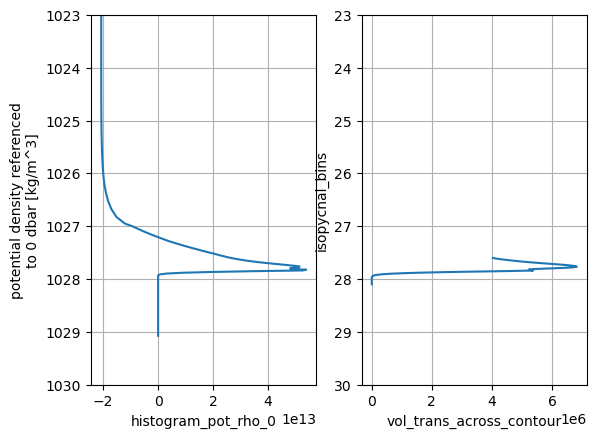

In [23]:
plt.subplot(1,2,1)
CSHT_mean.mean('time').sum('contour_index')[::-1].cumsum().plot(y='potrho0')
plt.ylim(1030,1023); plt.grid()
plt.subplot(1,2,2)
MT.mean('time').sum('contour_index')[::-1].cumsum().plot(y='isopycnal_bins')
plt.ylim(30,23); plt.grid()

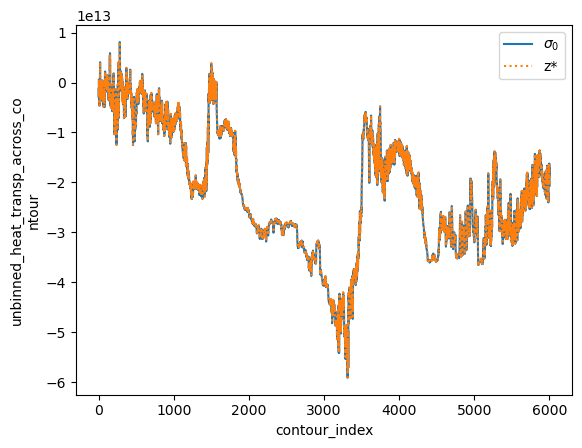

In [24]:
CSHT_mean.mean('time').sum('potrho0').cumsum().plot(label=r'$\sigma_0$')
unbinned_heat_transp_across_contour.mean('time').sum('st_ocean').cumsum().plot(linestyle=':',label='z*')
plt.legend()

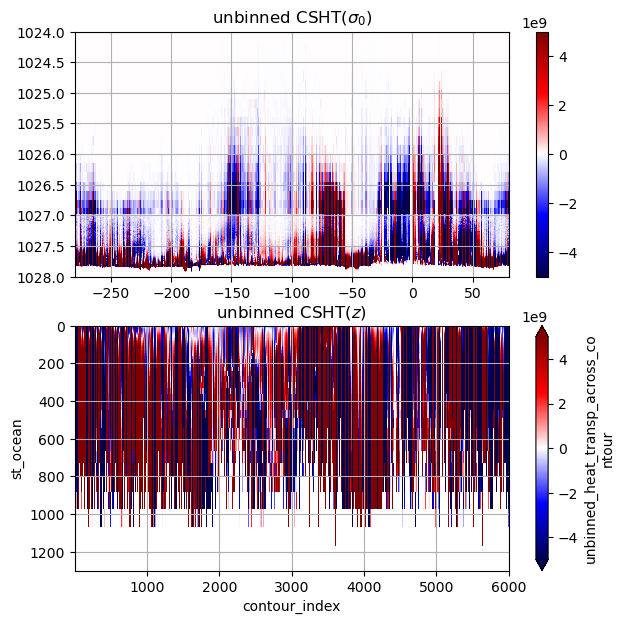

In [25]:

#Plotting the contour with a crazy colorbar, so We can see if the upper density levels match
# the U data plotted below
plt.figure(figsize=(7,7))
plt.subplot(2,1,1)
plt.pcolormesh(lon_along_contour,\
               CSHT_mean.potrho0,CSHT_mean.mean('time').T,\
               cmap='seismic',vmin=-5e9,vmax=5e9)
plt.title(r'unbinned CSHT($\sigma_0$)')
plt.ylim(1028,1024); plt.grid(); plt.colorbar()

plt.subplot(2,1,2)
unbinned_heat_transp_across_contour.mean('time').plot(y='st_ocean',\
                                                      cmap='seismic',vmin=-5e9,vmax=5e9)
plt.title(r'unbinned CSHT($z$)')
plt.ylim(1300,0); plt.grid(); 

total heat transport is negative, and the curve is reasonably smooth, and the vertically integrated curve looks a lot like the curve for the CSHT(z) data.

In [26]:
# # saving the mean monthly CSHT along potrho0
# CSHT_mean.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/CSHT_rho0_along_contour.nc')

In [27]:
tvol_contour['time']=u_along_unbinned_monthly.time

In [28]:
#rebinning the ASC speed using tvol
u_along_unbinned_monthly.load()
U_mean = histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = u_along_unbinned_monthly*tvol_contour.fillna(0)).rename({rho0_contour.name + '_bin': 'potrho0'})/\
                          histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = tvol_contour.fillna(0)).rename({rho0_contour.name + '_bin': 'potrho0'})

U_mean.name='U_along_contour'

In [29]:
#rebinning the ASC speed using tarea
U_meanArea = histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = u_along_unbinned_monthly*tarea_contour.fillna(0)).rename({rho0_contour.name + '_bin': 'potrho0'})/\
                          histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = tarea_contour.fillna(0)).rename({rho0_contour.name + '_bin': 'potrho0'})

U_meanArea.name='U_along_contour'

In [30]:
dzt_contour['time']=u_along_unbinned_monthly.time

In [31]:
#rebinning the ASC speed using dzt
U_meandzt = histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = u_along_unbinned_monthly*dzt_contour).rename({rho0_contour.name + '_bin': 'potrho0'})/\
                          histogram(rho0_contour, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = dzt_contour).rename({rho0_contour.name + '_bin': 'potrho0'})

U_meandzt.name='U_along_contour'

Sainity check on Ualong

(1250.0, 0.0)

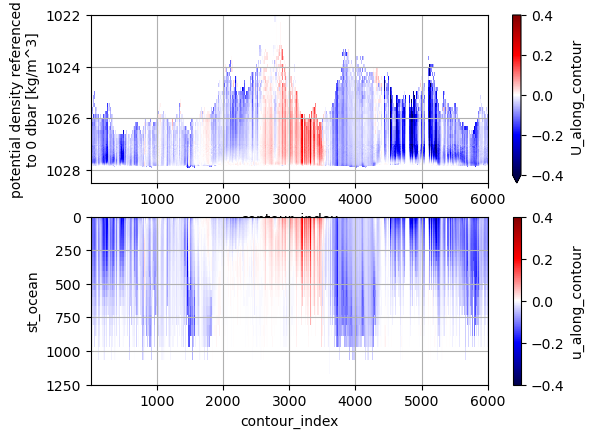

In [32]:
plt.subplot(2,1,1)
U_mean.mean('time').plot(y='potrho0',cmap='seismic',vmin=-0.4,vmax=0.4)
plt.ylim(1030,1020); plt.grid(); plt.ylim(1028.5,1022)
plt.subplot(2,1,2)
u_along_unbinned_monthly.mean('time').plot(y='st_ocean',cmap='seismic',vmin=-0.4,vmax=0.4)
plt.grid();  plt.ylim(1250,0)

Velocity contour looks reasonably similar to me.

Text(0.5, 1.0, 'Maximum U')

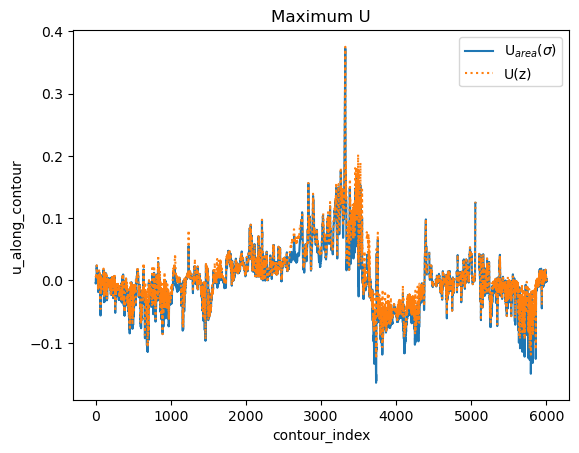

In [33]:
U_meanArea.isel(time=90).max('potrho0').plot(label=r'U$_{area}$($\sigma$)')
u_along_unbinned_monthly.isel(time=90).max('st_ocean').plot(linestyle=':',label='U(z)')
plt.legend()
plt.title('Maximum U')

Text(0.5, 1.0, 'Maximum U')

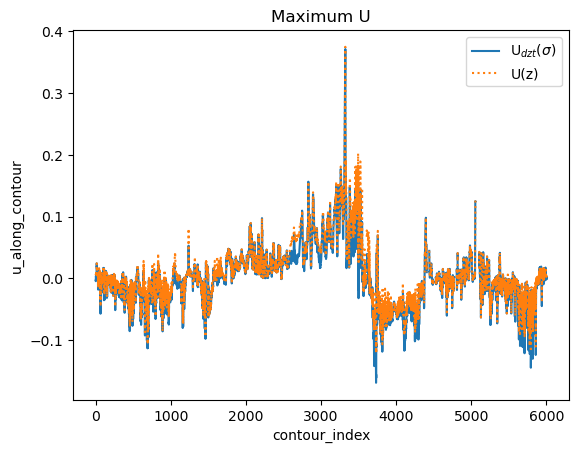

In [34]:
U_meandzt.isel(time=90).max('potrho0').plot(label=r'U$_{dzt}$($\sigma$)')
u_along_unbinned_monthly.isel(time=90).max('st_ocean').plot(linestyle=':',label='U(z)')
plt.legend()
plt.title('Maximum U')

Text(0.5, 1.0, 'Minimum U')

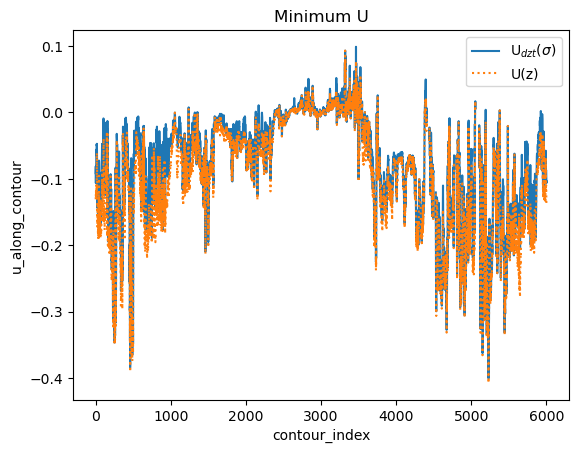

In [35]:
U_meandzt.isel(time=90).min('potrho0').plot(label=r'U$_{dzt}$($\sigma$)')
u_along_unbinned_monthly.isel(time=90).min('st_ocean').plot(linestyle=':',label='U(z)')
plt.legend()
plt.title('Minimum U')

Text(0.5, 1.0, 'avg -> Minimum U')

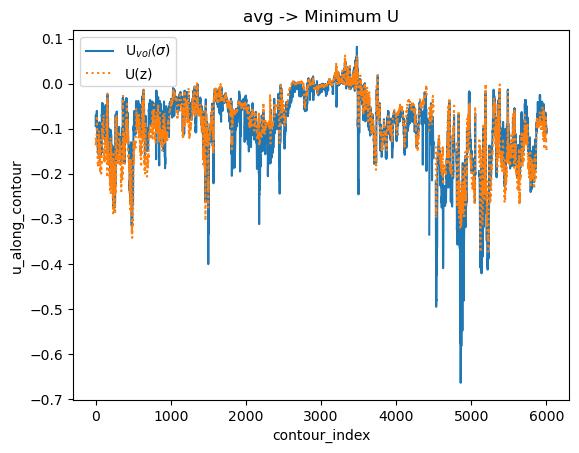

In [36]:
U_mean.mean('time').min('potrho0').plot(label=r'U$_{vol}$($\sigma$)')
u_along_unbinned_monthly.mean('time').min('st_ocean').plot(linestyle=':',label='U(z)')
plt.legend()
plt.title('avg -> Minimum U')

Ok, at each monthly output, the minimuns and maximuns between ASC speeds make sense. the problem is after we average it out

ASC speed along contour in sigma looks resonably similar to the original in z too

In [37]:
#saving the mean monthly U along potrho0
#U_mean.to_netcdf('/g/data/x77/wf4500/ASC_project/Post_process/Ualong_rho0_along_contour.nc')

## 3-degrees binning

Now that we have the monthly CSHT and along-slope speed in f(sigma), we can rebin the data into the classing 3 degrees bin.

In [38]:
lat_along_contour = np.array(lat_along_contour)
lon_along_contour = np.array(lon_along_contour)

In [39]:
	# convert to longitude coordinate and average into 3 degree longitude bins:
	# in degrees:
	bin_width = 3
	bin_spacing = 0.25
	lon_west = -280
	lon_east = 80
	
	# new coordinate and midpoints of longitude bins:
	full_lon_coord = np.arange(lon_west,lon_east+bin_spacing,bin_spacing)
	lon_bin_midpoints = np.arange(lon_west+bin_width/2,lon_east-bin_width/2,bin_spacing)
	n_bin_edges = len(full_lon_coord)
	
	# sum into longitude bins:
	# need to be very careful of loops, we can't just mask over longitude values, but instead pick indices 
	# on the isobath contour and sum continously along contour between defined indices.
	# (i.e. lon_along_contour is not monotonic)
	# find points on contour to define edges of longitude bins:
	bin_edge_indices = np.zeros(n_bin_edges)
	for lon_bin in range(n_bin_edges-1):
		# find first isobath point that has the right longitude:
		first_point = np.where(lon_along_contour>=full_lon_coord[lon_bin])[0][0]
		# then find all other isobath points with the same longitude as that first point:
		same_lon_points = np.where(lon_along_contour==lon_along_contour[first_point])[0]
		# we want the most southerly of these points on the same longitude line:
		bin_edge_indices[lon_bin] = same_lon_points[np.argmin(lat_along_contour[same_lon_points])]
		
	# define east/west edges:
	bin_edge_indices = bin_edge_indices.astype(int)
	bin_edge_indices_west = bin_edge_indices[:-int(bin_width/bin_spacing)-1]
	bin_edge_indices_east = bin_edge_indices[int(bin_width/bin_spacing):-1]
	n_bins = len(bin_edge_indices_west)
	
	
	lat_bin_midpoints = np.zeros(n_bins)
	for lon_bin in range(n_bins):
		# find nearest isobath point:
		lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
		lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]
	

In [40]:
#transposing for posterior use of indexes
CSHT_mean = CSHT_mean.transpose("time", "potrho0", "contour_index")
U_mean = U_mean.transpose("time", "potrho0", "contour_index")

Notice that we want to compare the CSHT binned with the massk transport, in each regime region. but for that we need to import the mass transports from the IAF simulation, and bin it into the same longitude bins as the CSHT. this will help us define the best $\sigma_0$ for the CDW in each shelf regime

In [41]:
# sum heat transport from isobath coord into new longitude coord:
nmonths=732
cross_slope_heat_trans = np.zeros([nmonths,np.size(targetbins)-1,n_bins])
U_binned = np.zeros([nmonths,np.size(targetbins)-1,n_bins])
Mass_binned = np.zeros([nmonths,51,n_bins])
for lon_bin in range(n_bins):
	heat_trans_this_bin0 = CSHT_mean[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	U_this_bin0 = U_mean[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	M_this_bin0 = MT[:,:,bin_edge_indices_west[lon_bin]:bin_edge_indices_east[lon_bin]]
	cross_slope_heat_trans[:,:,lon_bin] = np.sum(heat_trans_this_bin0,axis=2)
	U_binned[:,:,lon_bin] = np.nanmean(U_this_bin0,axis=2)
	Mass_binned[:,:,lon_bin] = np.nansum(M_this_bin0,axis=2)

lat_bin_midpoints = np.zeros(n_bins)
for lon_bin in range(n_bins):
	# find nearest isobath point:
	lon_index = np.where(lon_along_contour>=lon_bin_midpoints[lon_bin])[0][0]
	lat_bin_midpoints[lon_bin] = lat_along_contour[lon_index]


## CSHT vs ASC speed by regime ( Not accounting zonal convergence)

Let's use the mean mask, and calcualte the CHST profile and mean ASC speed per sigma layer, and see how these profiles look like. We can additionally calcualte the correlations and slopes. We have found taht over these large integrated areas, the zonal convergence tends to have not much effect. We will evaluate the effect of zonal convergence in the next section

In [42]:
#Importing average clustering mask
mean_mask=xr.open_dataset('/g/data/v45/txs156/ASC_classification/clustering_mask_time_mean.nc')
mean_mask=mean_mask.regimes_mask.load()
mean_mask = mean_mask.rename({'lon':'lon_bin_midpoints'})
mean_mask

<xarray.DataArray 'regimes_mask' (regime: 3, lon_bin_midpoints: 1428)> Size: 34kB
array([[ 1.,  1.,  1., ...,  1.,  1.,  1.],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * regime             (regime) <U7 84B 'Surface' 'Reverse' 'Deep'
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25

In [43]:
factor = float(CSHT_mean.mean('time').sum(('potrho0','contour_index')) / np.nansum(np.nanmean(cross_slope_heat_trans,axis=0)))
factor_mass = float(MT.mean('time').sum(('isopycnal_bins','contour_index')) / np.nansum(np.nanmean(Mass_binned,axis=0)))

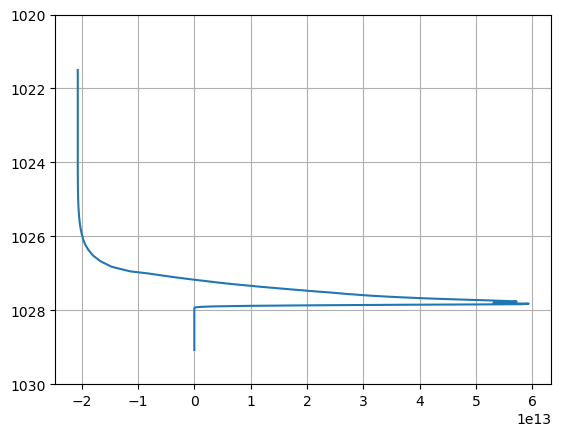

In [44]:
plt.plot(np.cumsum(np.nansum(np.nanmean(cross_slope_heat_trans,axis=0),axis=1)[::-1])*factor,CSHT_mean.potrho0[::-1])
plt.ylim(1030,1020); plt.grid()

lets create an xarray with CSHT

In [45]:
data_CSHT=xr.DataArray((cross_slope_heat_trans),name="binned_cross_slope_heat_trans",dims=["time","potrho0","lon_bin_midpoints"])
data_CSHT['potrho0']=np.array(CSHT_mean.potrho0)
data_CSHT['lon_bin_midpoints']=lon_bin_midpoints
data_CSHT['time']=CSHT_mean.time


In [46]:
data_M=xr.DataArray((Mass_binned),name="binned_mass_transport",dims=["time","isopycnal_bins","lon_bin_midpoints"])
data_M['isopycnal_bins']=np.array(MT.isopycnal_bins)
data_M['lon_bin_midpoints']=lon_bin_midpoints
data_M['time']=CSHT_mean.time

MT_masked = data_M*mean_mask*factor_mass

In [47]:
CSHT_masked = data_CSHT*mean_mask*factor

In [48]:
R0_1 = (CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R0_2 = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R0 = np.append(R0_1,R0_2[::-1])
depthfill = np.append(R0_1.st_ocean,R0_1.st_ocean[::-1])

R1_1=(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R1_2 = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R1 = np.append(R1_1,R1_2[::-1])

R2_1 = (CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R2_2  = ((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum()
R2 = np.append(R2_1,R2_2[::-1])

Text(0.5, 0, 'Upwards cumulative sum [$W$]')

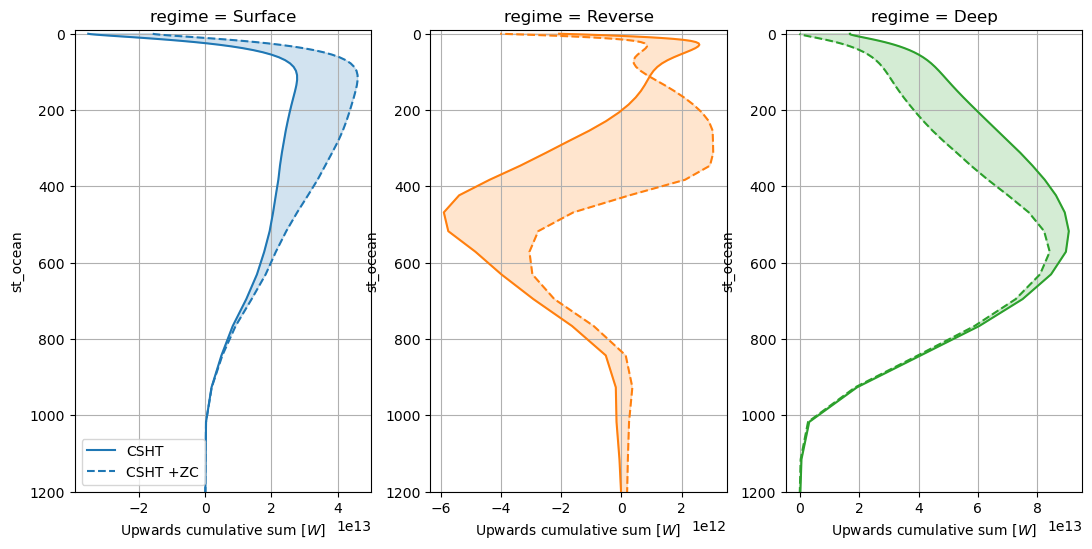

In [49]:
plt.figure(figsize=(13,6))


ax = plt.subplot(1,3,1)
(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',color='tab:blue',label='CSHT')
((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',linestyle='--',color='tab:blue',label='CSHT +ZC')
plt.fill(R0,depthfill,color='tab:blue',alpha=0.2)
plt.legend(); plt.ylim(1200,-10);plt.grid();plt.xlabel(r'Upwards cumulative sum [$W$]')

plt.subplot(1,3,2)
(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',color='tab:orange',label='CSHT')
((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',linestyle='--',color='tab:orange',label='CSHT +ZC')
plt.fill(R1,depthfill,color='tab:orange',alpha=0.2)
plt.ylim(1200,-10);plt.grid();plt.xlabel(r'Upwards cumulative sum [$W$]')

plt.subplot(1,3,3)
(CSHT_along.binned_cross_slope_heat_trans*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',color='tab:green',label='CSHT')
((CSHT_along.binned_cross_slope_heat_trans+CSHT_along.zonal_convergence)*mean_mask*factor).isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='st_ocean',linestyle='--',color='tab:green',label='CSHT +ZC')
plt.fill(R2,depthfill,color='tab:green',alpha=0.2)
plt.ylim(1200,-10);plt.grid();plt.xlabel(r'Upwards cumulative sum [$W$]')

The plot above shows the upwards cumulative sum of CSHT separate for the CSHT+ZC in a mean of the deep regimes bins. Notice that without the ZC, the total CSHT in these regions is negative. Now, the zonal covnergence helps closing the budget in this region especially at the surface. Since the ZC is the sum of all the heat transports from the shelf break i to the coast, that means that <font color='green'> heat leaving the shelf through DSW formation in Dense shelf regime is being compensated by heat coming from other regimes. And since this heat is already south of the 1km isobath, it would already be acessing the shelf. </font> 

<font color='blue'> We can also see that while all regimes are gaining heat from zonal convergence, the only one loosing heat by zonal convergence is the surface regime. Which suggests that this regime actually imports heat to the shelf, and the export to DSW locations </font> 

Text(0.5, 0, '$m^3\\ s^{-1}$')

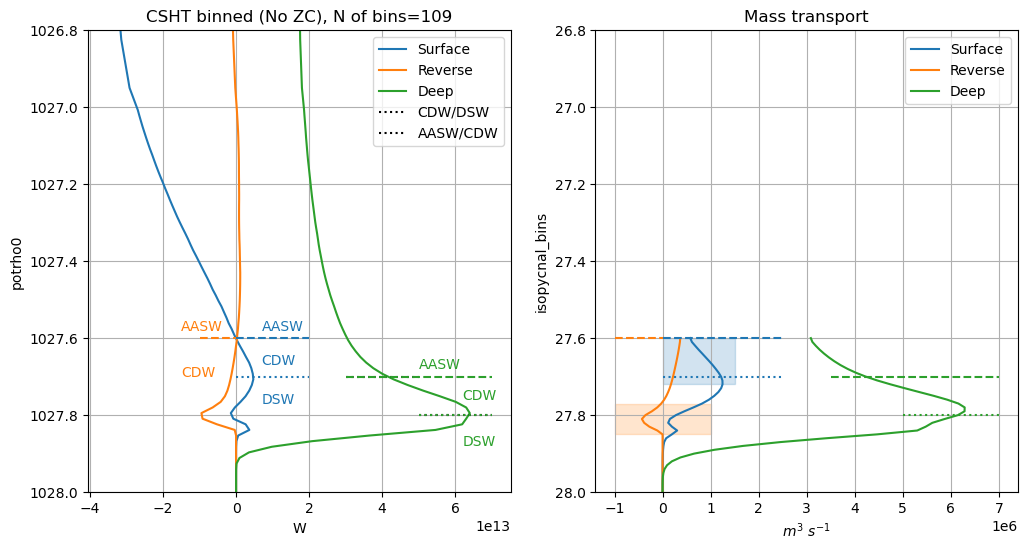

In [143]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)

CSHT_masked.isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='potrho0',label='Surface')
#plt.fill([-1e13,1e13,1e13,-1e13],[1027.72,1027.72,1027.6,1027.6],color='tab:blue',alpha=0.2)
CSHT_masked.isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='potrho0',label='Reverse')
#plt.fill([-.5e13,0,0,-.5e13],[1027.85,1027.85,1027.77,1027.77],color='tab:orange',alpha=0.2)
CSHT_masked.isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='potrho0',label='Deep')
plt.plot([5e13,7e13],[1027.8,1027.8], linestyle=':', color='black',label='CDW/DSW')
plt.plot([3e13,5e13],[1027.7,1027.7], linestyle=':', color='black',label='AASW/CDW')
plt.plot([5e13,7e13],[1027.8,1027.8], linestyle=':', color='tab:green')
plt.plot([3e13,7e13],[1027.7,1027.7], linestyle='--', color='tab:green')
plt.plot([0,2e13],[1027.6,1027.6], linestyle='--', color='tab:blue')
plt.plot([-1e13,0],[1027.6,1027.6], linestyle='--', color='tab:orange')
plt.plot([0,2e13],[1027.7,1027.7], linestyle=':', color='tab:blue')
plt.text(5e13,1027.68,'AASW',color='tab:green')
plt.text(-1.5e13,1027.58,'AASW',color='tab:orange')
plt.text(0.7e13,1027.58,'AASW',color='tab:blue')
plt.text(0.7e13,1027.67,'CDW',color='tab:blue')
plt.text(0.7e13,1027.77,'DSW',color='tab:blue')
plt.text(6.2e13,1027.76,'CDW',color='tab:green')
plt.text(-1.5e13,1027.7,'CDW',color='tab:orange')
plt.text(6.2e13,1027.88,'DSW',color='tab:green')
# plt.fill([2e13,6e13,6e13,2e13],[1027.765,1027.765,1027.6,1027.6],color='tab:green',alpha=0.2)
plt.ylim(1028,1026.8); plt.grid(); plt.legend(); plt.title('CSHT binned (No ZC), N of bins='+str(np.size(targetbins)))
plt.xlabel('W')

plt.subplot(1,2,2)
MT_masked.isel(regime=0).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='isopycnal_bins',label='Surface'); 
plt.fill([0,1.5e6,1.5e6,0],[27.72,27.72,27.6,27.6],color='tab:blue',alpha=0.2)
MT_masked.isel(regime=1).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='isopycnal_bins',label='Reverse')
plt.fill([-1e6,1e6,1e6,-1e6],[27.85,27.85,27.77,27.77],color='tab:orange',alpha=0.2)
MT_masked.isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().plot(y='isopycnal_bins',label='Deep')
plt.plot([5e6,7e6],[27.8,27.8], linestyle=':', color='tab:green')
plt.plot([0,2.5e6],[27.6,27.6], linestyle='--', color='tab:blue')
plt.plot([0,2.5e6],[27.7,27.7], linestyle=':', color='tab:blue')
plt.plot([3.5e6,7e6],[27.7,27.7], linestyle='--', color='tab:green')
plt.plot([-1e6,0],[27.6,27.6], linestyle='--', color='tab:orange')
# plt.fill([1e6,7e6,7e6,1e6],[27.765,27.765,27.6,27.6],color='tab:green',alpha=0.2)
plt.ylim(28,26.8); plt.grid(); plt.legend(); plt.title('Mass transport')
plt.xlabel(r'$m^3\ s^{-1}$')

In [51]:
CSHT_masked.isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().idxmax('potrho0')

<xarray.DataArray 'potrho0' ()> Size: 8B
array(1027.79471026)
Coordinates:
    regime   <U7 28B 'Deep'

In [52]:
MT_masked

<xarray.DataArray (time: 732, isopycnal_bins: 51, lon_bin_midpoints: 1428,
                   regime: 3)> Size: 1GB
array([[[[ 23.41503103,          nan,          nan],
         [ 14.24190605,          nan,          nan],
         [ 15.09787559,          nan,          nan],
         ...,
         [  2.98164833,          nan,          nan],
         [ 10.26151816,          nan,          nan],
         [ 12.36894425,          nan,          nan]],

        [[ 34.92978298,          nan,          nan],
         [  8.76586051,          nan,          nan],
         [  0.61263721,          nan,          nan],
         ...,
         [ -1.35715018,          nan,          nan],
         [ -9.39860848,          nan,          nan],
         [ -4.47039654,          nan,          nan]],

        [[ -5.0884748 ,          nan,          nan],
         [-33.03520073,          nan,          nan],
         [-46.31082533,          nan,          nan],
         ...,
...
         ...,
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan]],

        [[  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         ...,
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan]],

        [[  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         ...,
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan],
         [  0.        ,          nan,          nan]]]])
Coordinates:
  * isopycnal_bins     (isopycnal_bins) float64 408B 27.6 27.61 ... 28.09 28.1
  * lon_bin_midpoints  (lon_bin_midpoints) float64 11kB -278.5 -278.2 ... 78.25
  * time               (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31
  * regime             (regime) <U7 84B 'Surface' 'Reverse' 'Deep'

In [53]:
MT_masked.isel(regime=2).mean('time').sum('lon_bin_midpoints')[::-1].cumsum().idxmax('isopycnal_bins')

<xarray.DataArray 'isopycnal_bins' ()> Size: 8B
array(27.78)
Coordinates:
    regime   <U7 28B 'Deep'

The plot shows that at deep regime locations, the CSHT is positive, and northwards. this is not accounting for the zonal convergence tho. The zonal covnergence however compensates for this northward transport, and make the total here southward ~0... 


<font color='orange'> More interestingly, there is a clear southward transpor in very deep layers in the reverse regime, at $\sigma_0~1027.8$ . These are layers simlar to the one where DSW is exported. So it seems to me taht a combination of that heat coming from $\sigma_0~1027.8$ on reverse regime + the one coming at lighter layers in the deep regime is what actually is importing the heat</font> 

Based on the plots, it seems that the transports in sigma layers are very consitent to the the Water mass transports, which would help us understand better the CSHT of CDW. This is a motivation for us to rebin our CSHT into density layers

## ASC binning with [xgcm](https://xgcm.readthedocs.io/en/stable/transform.html)


In [54]:
%%time

st_ocean = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'st_ocean', session, n=1)
st_edges_ocean = cc.querying.getvar('01deg_jra55v140_iaf_cycle3', 'st_edges_ocean', session, n=1)

CPU times: user 2.04 s, sys: 1.02 s, total: 3.06 s
Wall time: 2.76 s


In [55]:
import xgcm

In [56]:

ds = xr.Dataset({'u_along_unbinned_monthly': u_along_unbinned_monthly, 'rho0_contour': rho0_contour})

# Note: Quantity must be extensive, e.g., ty_trans, vhrho_nt, uhrho_et, tx_trans but *not*, e.g., v, salt. 
#       If not extensive, then we need to multiply by dzt or dzu.
ds = ds.assign_coords({'st_edges_ocean': st_edges_ocean})
ds = ds.chunk({'st_edges_ocean': 76, 'st_ocean': 75}) #xgcm doesn't like it if there is more than 1 chunk in this axis

grid = xgcm.Grid(ds, coords={'Z': {'center': 'st_ocean', 'outer': 'st_edges_ocean'}}, periodic = False)
ds['rho0_contour_outer'] = grid.interp(ds.rho0_contour, 'Z', boundary='extend')
ds['rho0_contour_outer'] = ds['rho0_contour_outer'].chunk({'st_edges_ocean': 76})

u_transformed_cons = grid.transform(ds.u_along_unbinned_monthly,
                                           'Z',
                                           targetbins,
                                           method='conservative',
                                           target_data=ds.rho0_contour_outer)

### change name to fit previous bins because default xgcm naming is different
# pot_rho_2_outer is actually the CENTRE of bins (I guess the convention was defined for linear interpolation not conservative)
u_transformed_cons = u_transformed_cons.rename({'rho0_contour_outer': 'potrho0'})

In [57]:
u_transformed_cons.load()

<xarray.DataArray 'u_along_unbinned_monthly' (time: 732, contour_index: 6002,
                                              potrho0: 108)> Size: 4GB
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])
Coordinates:
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
  * time           (time) datetime64[ns] 6kB 1958-01-31 ... 2018-12-31
  * potrho0        (potrho0) float64 864B 1.022e+03 1.023e+03 ... 1.029e+03

Text(0.5, 1.0, 'Maximum U')

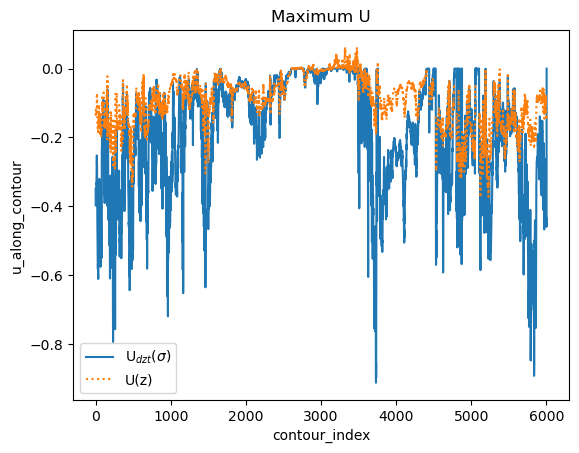

In [58]:
u_transformed_cons.mean('time').min('potrho0').plot(label=r'U$_{dzt}$($\sigma$)')
u_along_unbinned_monthly.mean('time').min('st_ocean').plot(linestyle=':',label='U(z)')
plt.legend()
plt.title('Maximum U')

ok, let me make a few tries for 1 year, one point along the isobath

In [59]:
sample_year=slice('2000-01','2000-12')

In [60]:
#getting the surface area along the contour for averaging U data
dzt = cc.querying.getvar(exp,'dzt',session).sel(yt_ocean=lat_range,time=sample_year)
dzt = dzt.sel(time=sample_year)
# dzt =dzt.sel(time=slice('2000-01','2000-12')).mean('time')
dzt_u=dzt.interp(xt_ocean=xu_ocean)
dzt_v=dzt.interp(yt_ocean=yu_ocean)

#getting contours of dzt
del x_along_1d,y_along_1d 
x_along_1d = dzt_u.rename(yt_ocean='y_ocean',xu_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
x_along_1d = x_along_1d.where(mask_x_numbered_1d>0, drop = True)
y_along_1d = dzt_v.rename(yu_ocean='y_ocean',xt_ocean='x_ocean').stack(contour_index = ['y_ocean', 'x_ocean'])
y_along_1d = y_along_1d.where(mask_y_numbered_1d>0, drop = True)

x_along_1d.load()
y_along_1d.load()

dzt_contour = xr.concat((x_along_1d.drop_vars('xt_ocean'), y_along_1d.drop_vars('yt_ocean')), dim = 'contour_index')
dzt_contour = dzt_contour.sortby(contour_ordering)
dzt_contour.coords['contour_index'] = contour_index_array


/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/xarray/core/dataset.py:271: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3

In [61]:
u_along2000 = u_along_unbinned_monthly.sel(time=sample_year)

In [62]:
rho0_2000 = rho0_contour.sel(time=sample_year)

In [63]:
dzt_contour['time']=rho0_2000.time

In [64]:
#rebinning the ASC speed using dzt
U_mean2000 = histogram(rho0_2000, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = u_along2000*dzt_contour).rename({rho0_2000.name + '_bin': 'potrho0'})/\
                          histogram(rho0_2000, 
                          bins = [targetbins], 
                          dim = ['st_ocean'],
                          weights = dzt_contour).rename({rho0_2000.name + '_bin': 'potrho0'})

U_mean2000.name='U_along_contour'

In [65]:
timestamp=7

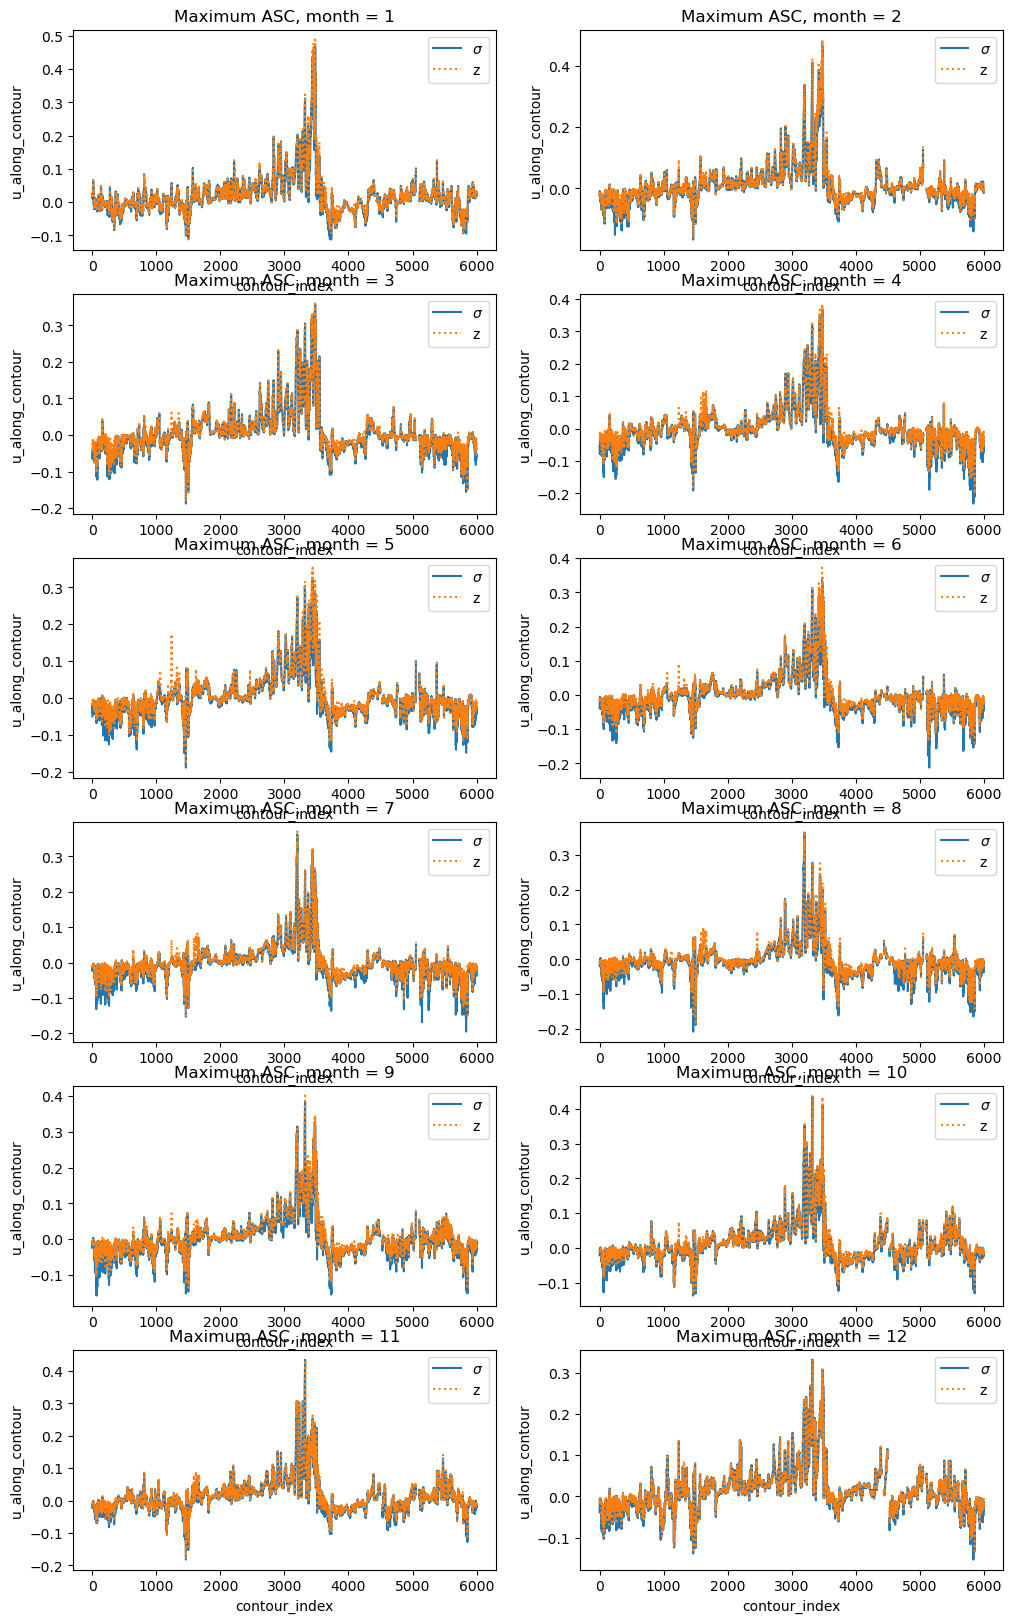

In [66]:
plt.figure(figsize=(12,20))

for n in range(0,12):
    plt.subplot(6,2,n+1)
    U_mean2000.isel(time=n).max('potrho0').plot(label='$\sigma$')
    u_along2000.isel(time=n).max('st_ocean').plot(linestyle=':',label='z')
    plt.legend();plt.title('Maximum ASC, month = ' + str(n+1))

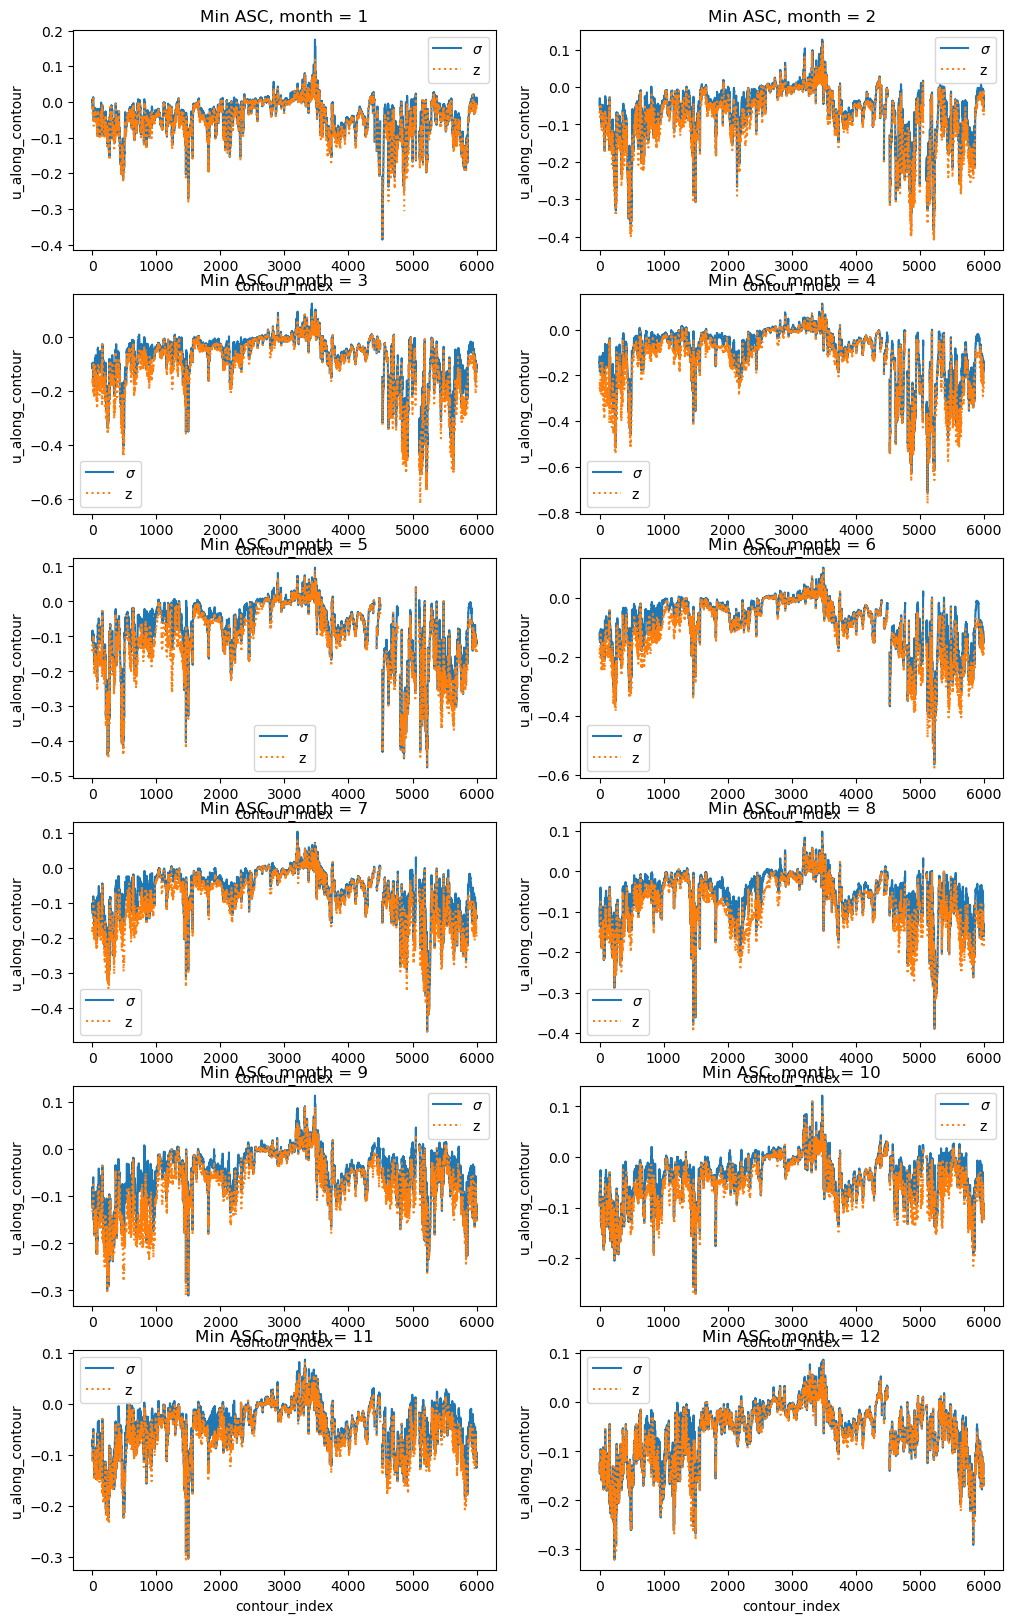

In [67]:
plt.figure(figsize=(12,20))

for n in range(0,12):
    plt.subplot(6,2,n+1)
    U_mean2000.isel(time=n).min('potrho0').plot(label='$\sigma$')
    u_along2000.isel(time=n).min('st_ocean').plot(linestyle=':',label='z')
    plt.legend();plt.title('Min ASC, month = ' + str(n+1))

Text(0.5, 1.0, 'annual mean, min on vertical')

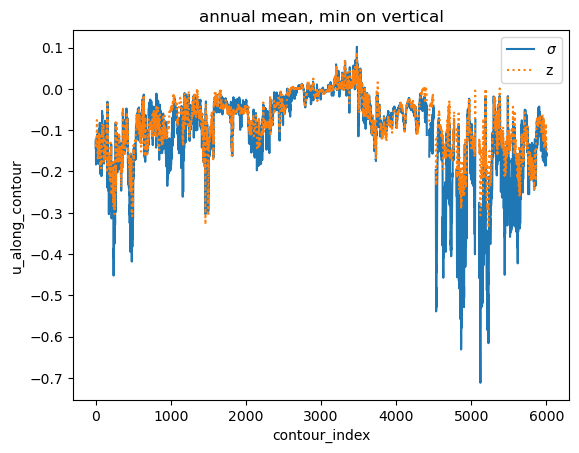

In [68]:

U_mean2000.mean('time').min('potrho0').plot(label='$\sigma$')
u_along2000.mean('time').min('st_ocean').plot(linestyle=':',label='z')
plt.legend();plt.title('annual mean, min on vertical')

Text(0.5, 1.0, 'annual mean, max on vertical')

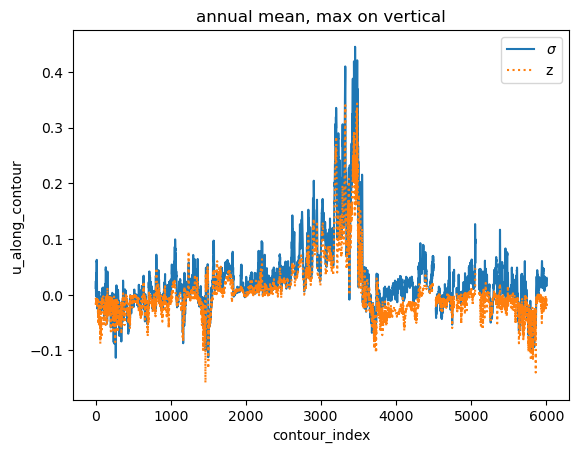

In [69]:

U_mean2000.mean('time').max('potrho0').plot(label='$\sigma$')
u_along2000.mean('time').max('st_ocean').plot(linestyle=':',label='z')
plt.legend();plt.title('annual mean, max on vertical')

In [70]:
#Delta minimum as a function of Time and contour. ST- sigma, so  it has to always be negative
Dmin_Ftc = u_along_unbinned_monthly.min('st_ocean') - U_meandzt.min('potrho0')

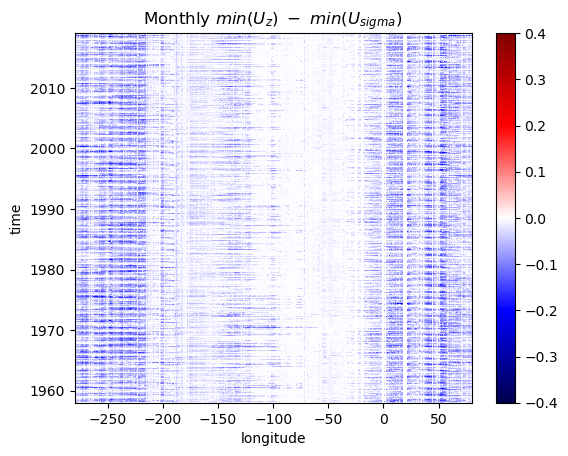

In [71]:
plt.pcolormesh(lon_along_contour,Dmin_Ftc.time,Dmin_Ftc,cmap='seismic',vmin=-.4,vmax=.4)
plt.title(r'Monthly $min(U_z)\ -\ min(U_{sigma})$'); plt.xlabel('longitude'); plt.ylabel('time')
plt.colorbar()

and indeed, in each timestep and each location, the delta of the minimuns is always negative, as it should be...

What happens then when we do the mean?

(1300.0, 0.0)

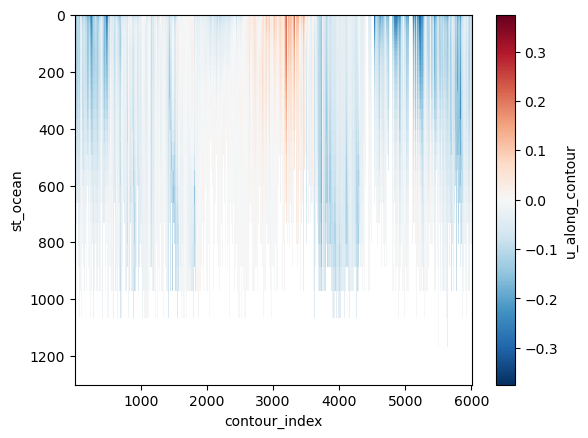

In [72]:
u_along_unbinned_monthly.mean('time').plot()
plt.ylim(1300,0)

(1028.0, 1022.0)

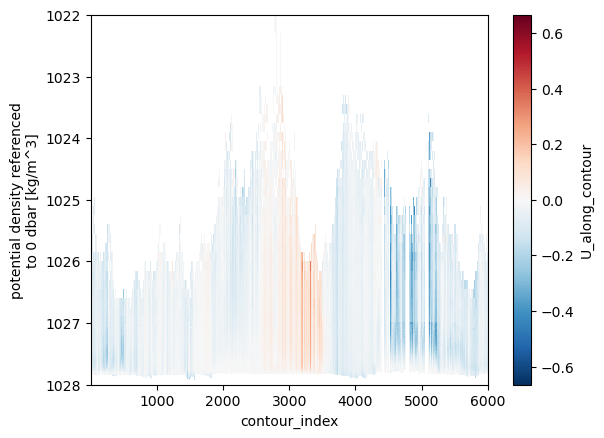

In [73]:
U_meandzt.mean('time').plot(y='potrho0')
plt.ylim(1028,1022)

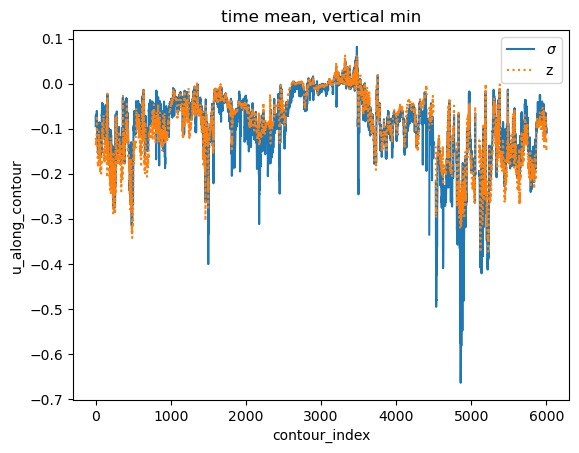

In [74]:
U_meandzt.mean('time').min('potrho0').plot(label=r'$\sigma$')
u_along_unbinned_monthly.mean('time').min('st_ocean').plot(linestyle=':',label='z')
plt.title('time mean, vertical min')
plt.legend()

the problem arises when we do the time-mean. lets do a hovmoller with annual mean

In [75]:
#Delta minimum as a function of Time and contour. ST- sigma, so  it has to always be negative
Dmin_Ft_annual = u_along_unbinned_monthly.resample(time='1y').mean().min('st_ocean') \
    - U_meandzt.resample(time='1y').mean().min('potrho0')
Dmin_Ft_annual
# 

<xarray.DataArray (time: 61, contour_index: 6002)> Size: 3MB
array([[-0.01412548, -0.01180463, -0.02246695, ...,  0.013778  ,
        -0.01197033,         nan],
       [ 0.02054392, -0.00151731,  0.0186904 , ...,  0.00449974,
         0.02714127,         nan],
       [ 0.00170357,  0.00019967, -0.01967882, ..., -0.0021071 ,
         0.0002305 ,         nan],
       ...,
       [ 0.00403177, -0.00128298, -0.01534745, ...,  0.00672449,
         0.04353954,         nan],
       [ 0.00042434, -0.00852993, -0.0067282 , ...,  0.00443484,
         0.0066023 ,         nan],
       [-0.01616112, -0.02591193, -0.03297016, ...,  0.01152966,
        -0.02080216,         nan]])
Coordinates:
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
  * time           (time) datetime64[ns] 488B 1958-12-31 ... 2018-12-31

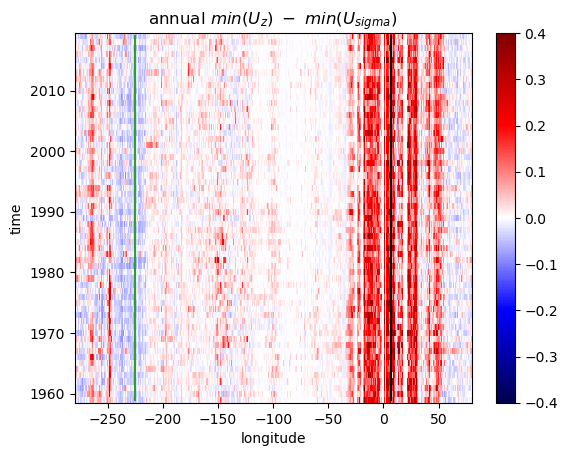

In [76]:
plt.pcolormesh(lon_along_contour,Dmin_Ft_annual.time,Dmin_Ft_annual,cmap='seismic',vmin=-.4,vmax=.4)
plt.title(r'annual $min(U_z)\ -\ min(U_{sigma})$'); plt.xlabel('longitude'); plt.ylabel('time')
plt.plot(np.zeros(np.shape(Dmin_Ft_annual.time))+7,Dmin_Ft_annual.time,color='black')
plt.plot(np.zeros(np.shape(Dmin_Ft_annual.time))-225,Dmin_Ft_annual.time,color='tab:green')
plt.colorbar()

Do we see the same in a climatology?

In [77]:
#Delta minimum as a function of Time and contour. ST- sigma, so  it has to always be negative
Dmin_Ft_clim = u_along_unbinned_monthly.groupby('time.month').mean().min('st_ocean') \
    - U_meandzt.groupby('time.month').mean().min('potrho0')
Dmin_Ft_clim

<xarray.DataArray (month: 12, contour_index: 6002)> Size: 576kB
array([[-1.55017134e-02, -1.79254194e-02, -1.40799085e-02, ...,
        -1.18905271e-02, -1.53986609e-02,             nan],
       [ 1.53566600e-03, -1.89751557e-02, -1.50403095e-02, ...,
        -1.33309783e-02, -9.34848798e-03,             nan],
       [ 7.82044857e-03, -5.96960943e-03, -2.14056655e-02, ...,
         6.84848455e-03,  1.54647533e-02,             nan],
       ...,
       [-1.09680300e-02, -8.97991612e-03, -1.97678941e-02, ...,
         3.66374580e-03,  2.41830339e-05,             nan],
       [ 4.76527342e-02,  4.37320916e-02,  4.74819750e-02, ...,
         5.83280250e-02,  4.46775968e-02,             nan],
       [ 8.46779719e-03,  2.61203945e-03,  2.59710848e-03, ...,
         1.27841234e-02,  9.40345600e-03,             nan]])
Coordinates:
  * contour_index  (contour_index) int64 48kB 1 2 3 4 5 ... 5999 6000 6001 6002
  * month          (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

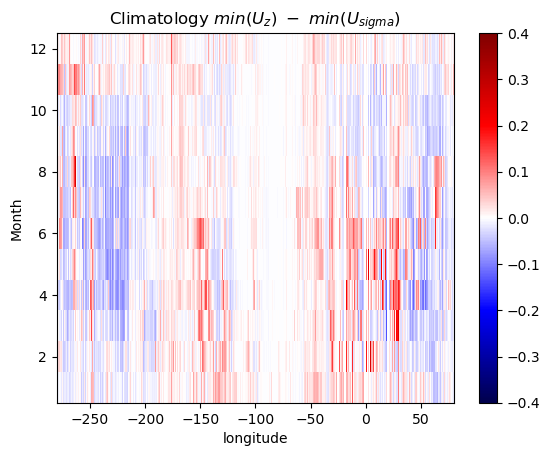

In [78]:
plt.pcolormesh(lon_along_contour,Dmin_Ft_clim.month,Dmin_Ft_clim,cmap='seismic',vmin=-.4,vmax=.4)
plt.title(r'Climatology $min(U_z)\ -\ min(U_{sigma})$'); plt.xlabel('longitude'); plt.ylabel('Month')
plt.colorbar()

of, we can see the the delta Min is positive in some cases in the monthly climatology., expecially at that region between -50 and 50. 

Perhaps what is going on here is that, the minimum ASC speed oscilates in $z$ seasonally, but it is maintainted in the same $\sigma$ seasonaly. If that is the case, when averaging different seasons in usin $z$ coords, the minimun per depth might decrease. But it wouldnt decrease in $sigma$. LEt's extract one contour around 10E, and see if indeed we have these minimum AS speeds varying in direction in $Z$

In [79]:
lon_along_contour = CSHT_along.lon_along_contour.isel(time=0,st_ocean=0).drop_vars(('time','st_ocean'))

In [80]:
#Cindex=4656 #-10
Cindex=4890 #+7
#Cindex=810 #-225
lon_along_contour.isel(contour_index=Cindex).values
#7 marks one of the regions where we have this positive deltas. so lets use the above defined Cindex

array(7.)

In [81]:
depth_min= u_along_unbinned_monthly.isel(contour_index=Cindex).idxmin('st_ocean')

(1300.0, 0.0)

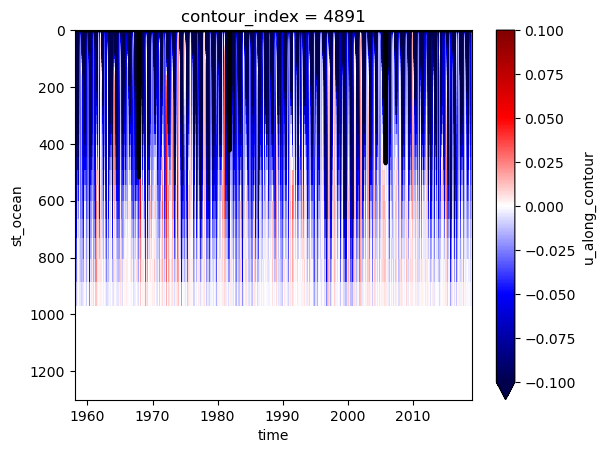

In [82]:
u_along_unbinned_monthly.isel(contour_index=Cindex).plot(y='st_ocean',vmin=-.1,vmax=.1,cmap='seismic')
plt.plot(u_along_unbinned_monthly.time,depth_min,color='black',linewidth=3)
plt.ylim(1300,0)

In [83]:
sigma_min= U_meandzt.isel(contour_index=Cindex).idxmin('potrho0')

(1300.0, 0.0)

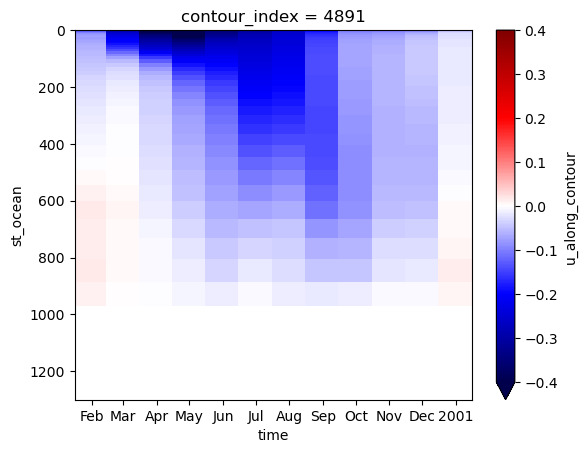

In [84]:
u_along_unbinned_monthly.isel(contour_index=Cindex).sel(time=slice('2000-01','2000-12'))\
    .plot(y='st_ocean',vmin=-.4,vmax=.4,cmap='seismic')
#plt.plot(u_along_unbinned_monthly.time,depth_min,color='black',linewidth=3)
plt.ylim(1300,0)

(1028.0, 1025.0)

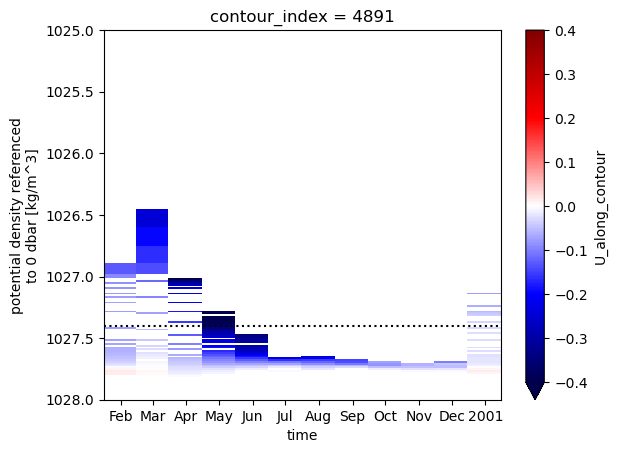

In [85]:
U_meandzt.isel(contour_index=Cindex).sel(time=slice('2000-01','2000-12'))\
    .plot(y='potrho0',vmin=-.4,vmax=.4,cmap='seismic')
#plt.plot(U_meandzt.time,np.zeros(np.size(U_meandzt.time))+1027.53, linestyle=':',color='tab:green')    
plt.plot(U_meandzt.time,np.zeros(np.size(U_meandzt.time))+1027.4, linestyle=':',color='black') 
#plt.plot(U_meandzt.time,sigma_min,color='black',linewidth=1)
plt.ylim(1028,1025)